# calculate mean and std

In [2]:
import os
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

class SimpleImageLoader(Dataset):
    def __init__(self, folder_path, transform=None):
        self.image_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith(('png', 'jpg', 'jpeg'))]
        self.transform = transform
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, index):
        img_path = self.image_files[index]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

def compute_mean_std(loader):
    channel_sum, channel_sq_sum, num_batches = 0, 0, 0
    
    for images in loader:
        images = images.view(images.size(0), images.size(1), -1)
        channel_sum += torch.mean(images, dim=[0, 2])
        channel_sq_sum += torch.mean(images ** 2, dim=[0, 2])
        num_batches += 1

    mean = channel_sum / num_batches
    std = (channel_sq_sum / num_batches - mean ** 2) ** 0.5
    return mean, std

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Create the dataset
dataset = SimpleImageLoader('dataset/train', transform=transform)
loader = DataLoader(dataset, batch_size=10, num_workers=0, shuffle=False)

# Calculate mean and std deviation
mean, std = compute_mean_std(loader)
print(f"Calculated Mean: {mean}")
print(f"Calculated Std Deviation: {std}")



Calculated Mean: tensor([0.6984, 0.5219, 0.4197])
Calculated Std Deviation: tensor([0.1396, 0.1318, 0.1236])


In [3]:
# Create the dataset
dataset = SimpleImageLoader('dataset/val', transform=transform)
loader = DataLoader(dataset, batch_size=10, num_workers=0, shuffle=False)

# Calculate mean and std deviation
mean, std = compute_mean_std(loader)
print(f"Calculated Mean: {mean}")
print(f"Calculated Std Deviation: {std}")

Calculated Mean: tensor([0.6982, 0.5217, 0.4194])
Calculated Std Deviation: tensor([0.1395, 0.1320, 0.1239])


# use least used gpu

In [4]:
import subprocess
import os

def get_least_used_gpu():
    # Command to get GPU usage (memory and compute)
    smi_output = subprocess.check_output(['nvidia-smi', '--query-gpu=memory.used,utilization.gpu', '--format=csv,noheader,nounits']).decode()

    # Parse the output to get a list of (memory used, gpu utilization) tuples
    gpu_stats = [tuple(map(int, line.split(', '))) for line in smi_output.strip().split('\n')]
    
    # Calculate a simple score by adding memory usage and GPU utilization (you can customize this)
    usage_scores = [memory + utilization for memory, utilization in gpu_stats]

    # Get the index of the GPU with the lowest score
    least_used_gpu = usage_scores.index(min(usage_scores))
    return least_used_gpu

# Set the least used GPU as visible
least_used_gpu = get_least_used_gpu()
os.environ['CUDA_VISIBLE_DEVICES'] = str(least_used_gpu)
print("Using GPU:", least_used_gpu)


Using GPU: 2


In [5]:
from PIL import Image
import os

# Set the directory path where your images are stored
directory = 'dataset/val'

# Loop through the files in the directory
for filename in os.listdir(directory)[:10]:  # Only the first 10 images
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        image_path = os.path.join(directory, filename)
        with Image.open(image_path) as img:
            print(f'{filename}: {img.size} (width x height)')


ISIC_4730860.jpg: (127, 127) (width x height)
ISIC_7506263.jpg: (139, 139) (width x height)
ISIC_2425892.jpg: (125, 125) (width x height)
ISIC_7331813.jpg: (141, 141) (width x height)
ISIC_4875463.jpg: (151, 151) (width x height)
ISIC_5993069.jpg: (143, 143) (width x height)
ISIC_8949094.jpg: (147, 147) (width x height)
ISIC_3376895.jpg: (119, 119) (width x height)
ISIC_0982091.jpg: (103, 103) (width x height)
ISIC_5558456.jpg: (161, 161) (width x height)


In [ ]:
# Model and optimizer setup

import torch
from timm.scheduler.cosine_lr import CosineLRScheduler
from torch.optim import Adam
from matplotlib import pyplot as plt

model = torch.nn.Linear(3, 3)
optimizer = Adam(model.parameters(), lr=0.01)

# Scheduler setup
scheduler = CosineLRScheduler(
                                optimizer,
                                t_initial=10,
                                lr_min=1e-6,
                                cycle_mul=2.0,
                                cycle_decay=0.5,
                                cycle_limit=4,
                                warmup_t=5,
                                warmup_lr_init=1e-5,
                                warmup_prefix=False,
                                t_in_epochs=True,
                                k_decay=0.95,
                                initialize=True
                                )

# Simulate the scheduler over 100 epochs
epochs = list(range(1, 101))
x = []
y = []

for epoch in range(100):
    y.append((optimizer.param_groups[0]['lr']))
    x.append(epoch)
    scheduler.step(epoch)

plt.plot(x,y)


In [15]:

=import os
from utils import device, calculate_auc
from Project import Project
from data import get_dataloader
from data.transformation import train_transform, val_transform
from logger import logging


project = Project()

params = {
    'lr': 2e-5,
    'weight_decay': .001,
    'batch_size': 64,
    'epochs': 1000,
    'model': 'resnet50-VS_loss-timm-im64',
    'train_resnet': True,  # Allows controlling trainability of ResNet from params
    'omega': 0.99,  # Example value for omega
    'gamma': 1.0,  # Example value for gamma
    'tau': 1.5    # Example value for tau
}

# Log device usage
logging.info(f'Using device={device}: 🚀')

class_mapping = {
    'benign': 0,
    'malignant': 1
    }
columns_to_use = None

import torchvision.transforms as transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize all images to 128x128
    transforms.ToTensor()
])
# Data loading
train_dl, val_dl, test_dl = get_dataloader( train_dir=os.path.join(project.data_dir, "train"),
                                            val_dir=os.path.join(project.data_dir, "val"),
                                            train_csv=os.path.join(project.data_dir, "train_age_fixed.csv"),
                                            val_csv=os.path.join(project.data_dir, "val_age_fixed.csv"),
                                            columns_to_use=columns_to_use,
                                            class_mapping = class_mapping,
                                            train_transform=transform,
                                            val_transform=transform,
                                            split=(0.6, 0.4),
                                            batch_size=params['batch_size'],
                                            pin_memory=True,
                                            num_workers=8)

2024-07-31 11:21:34,238 - [INFO] - Using device=cuda: 🚀
/home/mdi220/Simulations/Git_repository/skin_cancer/data/MyDataset.py:56: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
2024-07-31 11:21:57,699 - [INFO] - Train samples=240635, Validation samples=96254, Test samples=64170


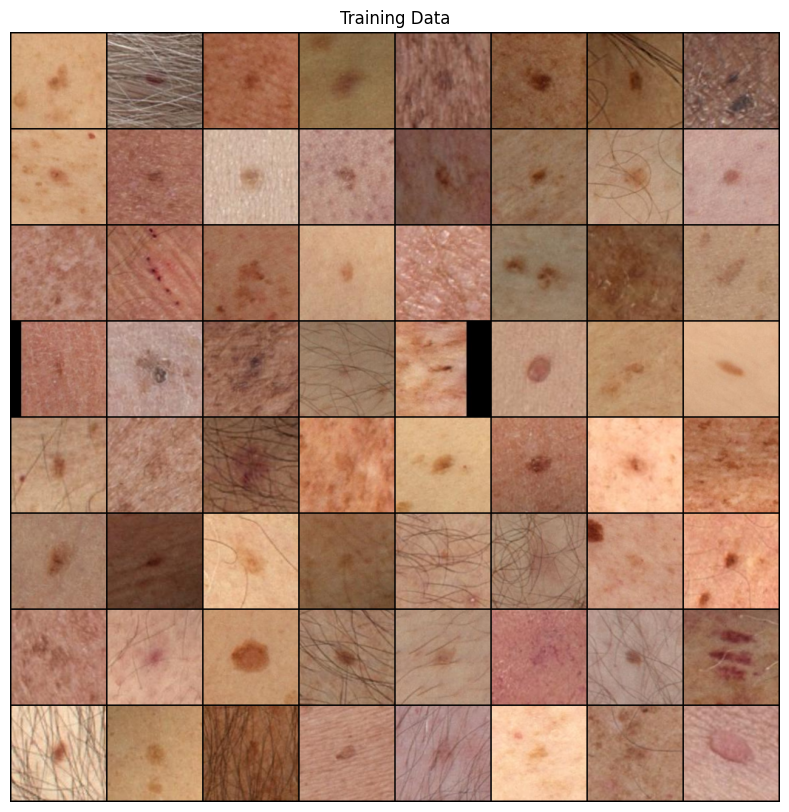

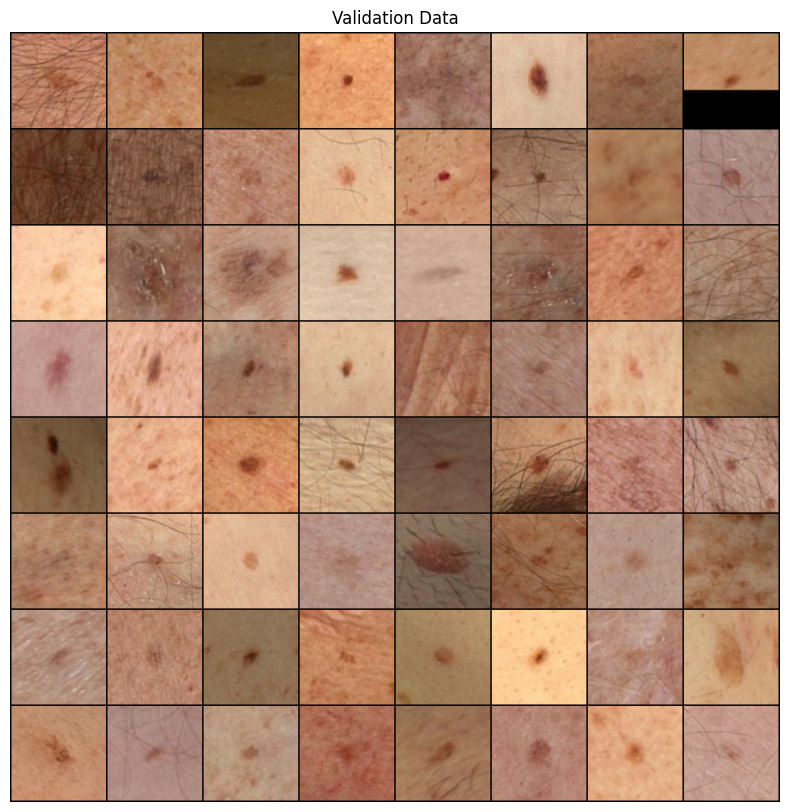

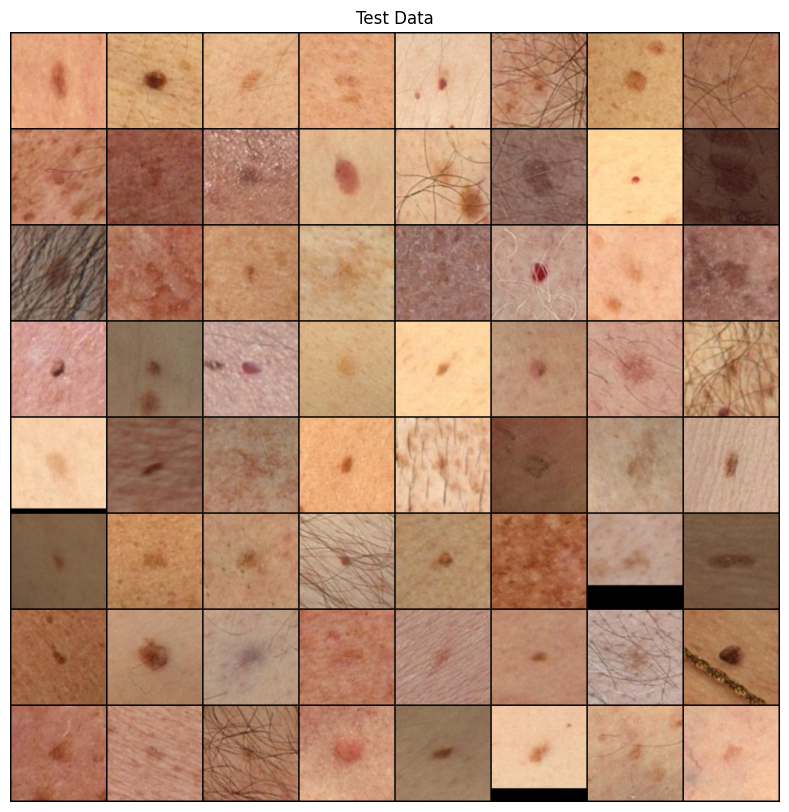

In [16]:
import matplotlib.pyplot as plt
import torchvision

def show_images(dataloader, title):
    
    # Get a batch of training data
    inputs, classes = next(iter(dataloader))
    
    # Make a grid from batch
    out = torchvision.utils.make_grid(inputs)
    plt.figure(figsize=(15, 10))
    plt.imshow(out.numpy().transpose((1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Example usage:
show_images(train_dl, 'Training Data')
show_images(val_dl, 'Validation Data')
show_images(test_dl, 'Test Data')
